In [4]:
pip install pandasql

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26800 sha256=60ffb50e08067279bef47f0b7cdc3dd226ec81a488fecf9b0bfa85f25ac10756
  Stored in directory: c:\users\rvanjani\appdata\local\pip\cache\wheels\68\5d\a5\edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import sqlite3
from pandasql import sqldf
import matplotlib.pyplot as plt

#load in data sets
boxoffice = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_table('zippedData/rt.movie_info.tsv.gz')
reviews = pd.read_table('zippedData/rt.reviews.tsv.gz', encoding='windows-1252')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', index_col=0)
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', index_col=0)

#connect to database
conn = sqlite3.connect('zippedData/im.db')

pysqldf = lambda q: sqldf(q, globals()) # needed this to merge SQL with pandas dataframe for our master dataframe

In [2]:
#Joined two tables (movie_basics and movie_ratings) within the SQL dataframe
joined = pd.read_sql("SELECT * FROM movie_basics mb JOIN movie_ratings mr ON mb.movie_id=mr.movie_id", conn)

#Joined the previous merged SQL tables to another pandas data frame with the movie title as the identifier
q = """
SELECT * FROM joined j 
JOIN movie_budgets mb ON mb.movie=j.primary_title 
JOIN movies m ON m.original_title=j.original_title
"""
master_df = pysqldf(q).drop_duplicates(subset='primary_title', keep='first')

#Dropping columns that are not relevant for our analysis for a cleaner look
new_master_df = master_df.drop(["original_title", "id", "start_year", "movie", "title", 
                                "genre_ids", "original_language"], axis=1)

#Renaming columns to differentiate between the two datasets 
new_master_df = new_master_df.rename(columns={"vote_average": "tmdb_vote_average",
                                              "vote_count": "tmdb_vote_count", "averagerating": "imdb_average_rating", 
                                              "numvotes": "imdb_vote_count"})
#Converting genres column into a list
new_master_df["genres"] = new_master_df["genres"].str.split(',')

new_master_df

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,release_date,production_budget,domestic_gross,worldwide_gross,popularity,release_date,tmdb_vote_average,tmdb_vote_count
0,tt0249516,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,8248,"Dec 31, 2012","$45,000,000",$0,"$73,706",4.705,2013-05-07,2.1,46
1,tt0326592,The Overnight,88.0,None,7.5,24,"Jun 19, 2015","$200,000","$1,109,808","$1,165,996",6.576,2015-06-19,6.0,200
2,tt0337692,On the Road,124.0,"[Adventure, Drama, Romance]",6.1,37886,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302",8.919,2012-12-21,5.6,518
3,tt0359950,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,275300,"Dec 25, 2013","$91,000,000","$58,236,838","$187,861,183",10.743,2013-12-25,7.1,4859
4,tt0365907,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,105116,"Sep 19, 2014","$28,000,000","$26,017,685","$62,108,587",19.373,2014-09-19,6.3,1685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,tt7401588,Instant Family,118.0,"[Comedy, Drama]",7.4,46728,"Nov 16, 2018","$48,000,000","$67,363,237","$119,736,188",22.634,2018-11-16,7.6,782
2839,tt7766254,Big,99.0,[Documentary],8.5,6,"Jun 3, 1988","$18,000,000","$114,968,774","$151,668,774",15.031,1988-06-03,7.0,1813
2841,tt7784604,Hereditary,127.0,"[Drama, Horror, Mystery]",7.3,151571,"Jun 8, 2018","$10,000,000","$44,069,456","$70,133,905",26.185,2018-06-08,7.0,2491
2848,tt8043306,Teefa in Trouble,155.0,"[Action, Comedy, Crime]",7.4,2724,"Jul 20, 2018","$1,500,000",$0,"$98,806",4.486,2018-07-20,7.6,11


In [3]:
#Converting budget values from string into integers for calculations/graphs/further analysis
new_master_df['domestic_gross'] = new_master_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['production_budget'] = new_master_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['worldwide_gross'] = new_master_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)

final_master_df = new_master_df
final_master_df

C:\Users\rvanjani\AppData\Local\Temp\ipykernel_50444\2530156305.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_master_df['domestic_gross'] = new_master_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_50444\2530156305.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new_master_df['production_budget'] = new_master_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
C:\Users\rvanjani\AppData\Local\Temp\ipykernel_50444\2530156305.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expr

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,release_date,production_budget,domestic_gross,worldwide_gross,popularity,release_date,tmdb_vote_average,tmdb_vote_count
0,tt0249516,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,8248,"Dec 31, 2012",45000000,0,73706,4.705,2013-05-07,2.1,46
1,tt0326592,The Overnight,88.0,None,7.5,24,"Jun 19, 2015",200000,1109808,1165996,6.576,2015-06-19,6.0,200
2,tt0337692,On the Road,124.0,"[Adventure, Drama, Romance]",6.1,37886,"Mar 22, 2013",25000000,720828,9313302,8.919,2012-12-21,5.6,518
3,tt0359950,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,275300,"Dec 25, 2013",91000000,58236838,187861183,10.743,2013-12-25,7.1,4859
4,tt0365907,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,105116,"Sep 19, 2014",28000000,26017685,62108587,19.373,2014-09-19,6.3,1685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,tt7401588,Instant Family,118.0,"[Comedy, Drama]",7.4,46728,"Nov 16, 2018",48000000,67363237,119736188,22.634,2018-11-16,7.6,782
2839,tt7766254,Big,99.0,[Documentary],8.5,6,"Jun 3, 1988",18000000,114968774,151668774,15.031,1988-06-03,7.0,1813
2841,tt7784604,Hereditary,127.0,"[Drama, Horror, Mystery]",7.3,151571,"Jun 8, 2018",10000000,44069456,70133905,26.185,2018-06-08,7.0,2491
2848,tt8043306,Teefa in Trouble,155.0,"[Action, Comedy, Crime]",7.4,2724,"Jul 20, 2018",1500000,0,98806,4.486,2018-07-20,7.6,11


In [4]:
#Assuming that the production budget includes all the costs of production, we are calculating the net profit from the 
#gross revenue and creating them into two new columns
final_master_df['domestic_profit'] = final_master_df['domestic_gross'] - final_master_df['production_budget']
final_master_df['worldwide_profit'] = final_master_df['worldwide_gross'] - final_master_df['production_budget']

# dropped additional columns and removed null values from genres
final = final_master_df
final = final.drop(['release_date'], axis=1)
final['genres'] = final['genres'].dropna()
final = final.dropna()
final.reset_index(drop=True)

#separated the rows to have the list of genres per film be seperated
final = final.explode('genres')
final

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
0,tt0249516,Foodfight!,91.0,Action,1.9,8248,45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Animation,1.9,8248,45000000,0,73706,4.705,2.1,46,-45000000,-44926294
0,tt0249516,Foodfight!,91.0,Comedy,1.9,8248,45000000,0,73706,4.705,2.1,46,-45000000,-44926294
2,tt0337692,On the Road,124.0,Adventure,6.1,37886,25000000,720828,9313302,8.919,5.6,518,-24279172,-15686698
2,tt0337692,On the Road,124.0,Drama,6.1,37886,25000000,720828,9313302,8.919,5.6,518,-24279172,-15686698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,tt7784604,Hereditary,127.0,Mystery,7.3,151571,10000000,44069456,70133905,26.185,7.0,2491,34069456,60133905
2848,tt8043306,Teefa in Trouble,155.0,Action,7.4,2724,1500000,0,98806,4.486,7.6,11,-1500000,-1401194
2848,tt8043306,Teefa in Trouble,155.0,Comedy,7.4,2724,1500000,0,98806,4.486,7.6,11,-1500000,-1401194
2848,tt8043306,Teefa in Trouble,155.0,Crime,7.4,2724,1500000,0,98806,4.486,7.6,11,-1500000,-1401194


In [5]:
max(final['worldwide_profit'])

1748134200

Data analysis brainstorming:

How genre impacts profitability of a movie
Does higher rating mean more profitability
How does runtime impact profitability
How does budget impact profit margins (does a higher budget lead to a higher or lower profit margin on average?)

In [6]:
final[final['worldwide_profit'] == 1748134200 ]

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
2334,tt4154756,Avengers: Infinity War,149.0,Action,8.5,670926,300000000,678815482,2048134200,80.773,8.3,13948,378815482,1748134200
2334,tt4154756,Avengers: Infinity War,149.0,Adventure,8.5,670926,300000000,678815482,2048134200,80.773,8.3,13948,378815482,1748134200
2334,tt4154756,Avengers: Infinity War,149.0,Sci-Fi,8.5,670926,300000000,678815482,2048134200,80.773,8.3,13948,378815482,1748134200


In [7]:
max(final['popularity']) 

#the highest popularity rating was given to the movie that made the highest worldwide profit

80.773

Avengers Infinity War made the most net profit worldwide

Potential hypothesis testing:

Null Hypothesis: The popularity rating does not affect the worldwide profitability or has a negative effect
Alternate Hypothesis: The popularity rating positively impacts the worldwide profitability
Another thing to think about is that, we are assuming worldwide profitability includes domestic profitability. We are also assuming that domestic refers to the United States, so even if a movie is international we assume that the domestic budget values assume that its the US for simplicity sake

In [8]:
max(final['domestic_profit'])

500059566

In [9]:
final[final['domestic_profit'] == 500059566 ]

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
1066,tt1825683,Black Panther,134.0,Action,7.3,516148,200000000,700059566,1348258224,44.14,7.4,12365,500059566,1148258224
1066,tt1825683,Black Panther,134.0,Adventure,7.3,516148,200000000,700059566,1348258224,44.14,7.4,12365,500059566,1148258224
1066,tt1825683,Black Panther,134.0,Sci-Fi,7.3,516148,200000000,700059566,1348258224,44.14,7.4,12365,500059566,1148258224


In [10]:
500059566 > 1748134200 #Avengers Infinity War made more than Black Panther which makes sense

False

Both films that made the most profit included the same genres [Action, Adventure, Sci-Fi]

A potential hypothesis testing can be:

Null Hypothesis: The genre does not impact profitability
Alternate Hypothesis: The genre does impact profitability
This might be a difficult one to do, but just an idea. Both are Marvel movies, but that information is not given in our master dataframe.

In [11]:
final[final['imdb_average_rating'] == max(final['imdb_average_rating'])]

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
575,tt1455256,The Wall,78.0,Documentary,9.2,8,3000000,1803064,4495262,8.142,6.1,407,-1196936,1495262


In [12]:
final[final['tmdb_vote_average'] == max(final['tmdb_vote_average'])]
#all of them only have one vote count and very low popularity (assuming these values are percentage values)

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
435,tt1334515,Bad Company,87.0,Thriller,5.1,10,70000000,30157016,69157016,1.836,10.0,1,-39842984,-842984
1007,tt1772317,Nerve,83.0,Comedy,6.8,88,20000000,38583626,70652284,0.600,10.0,1,18583626,50652284
1007,tt1772317,Nerve,83.0,Drama,6.8,88,20000000,38583626,70652284,0.600,10.0,1,18583626,50652284
1488,tt2248739,Departure,109.0,Drama,6.7,1680,1100000,0,27561,0.885,10.0,1,-1100000,-1072439
1488,tt2248739,Departure,109.0,Romance,6.7,1680,1100000,0,27561,0.885,10.0,1,-1100000,-1072439
2056,tt3319070,Emma,70.0,Thriller,4.7,133,5900000,22231658,37831658,0.600,10.0,1,16331658,31931658
2089,tt3406296,Chemical Cut,83.0,Drama,5.4,111,1000000,0,0,0.639,10.0,1,-1000000,-1000000


Another hypothesis testing could be analyzing the relationship between vote count and popularity rate.

The lower the vote count the lower the popularity compared to higher vote count and higher popularity

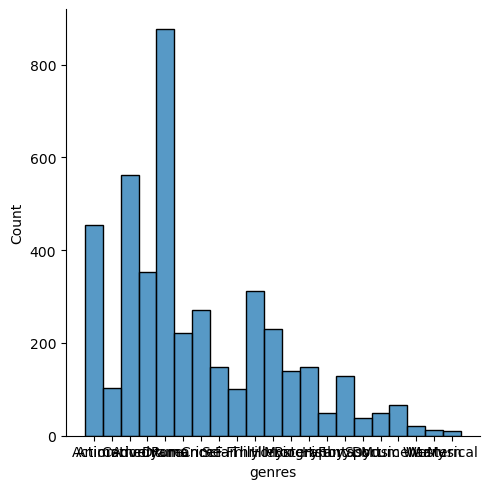

In [13]:
%matplotlib inline
import seaborn as sns

sns.displot(data = final, x = "genres")

Hypothesis Testing
Null Hypothesis: The genre does not impact profitability
The genre does not positively or negatively impact probability

Alternate Hypothesis: The genre does impact profitability
The genre does positively or negatively impact probability

<Axes: xlabel='worldwide_profit', ylabel='genres'>

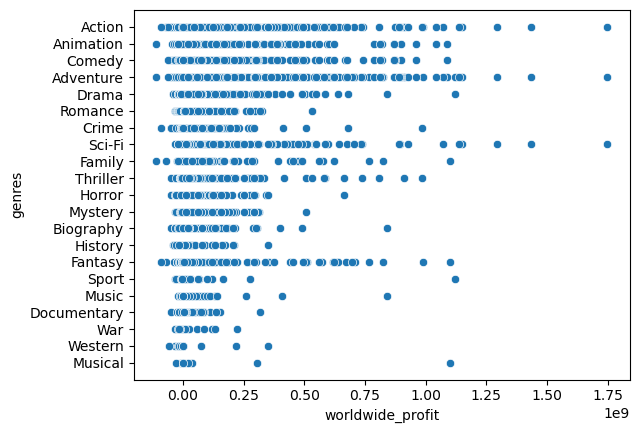

In [14]:
sns.scatterplot(y="genres",
x="worldwide_profit",
data=final)

In [15]:
final['genres'].value_counts()

Drama          876
Comedy         562
Action         454
Adventure      352
Thriller       312
Crime          271
Horror         230
Romance        221
Sci-Fi         149
Biography      148
Mystery        139
Fantasy        128
Animation      103
Family         101
Documentary     67
History         50
Music           48
Sport           38
War             21
Western         13
Musical         10
Name: genres, dtype: int64

In [16]:
runtime = pd.DataFrame(final, columns=['runtime_minutes'])
print(runtime.describe()) #runtime statistics across all genres

       runtime_minutes
count      4293.000000
mean        106.106918
std          17.402236
min          41.000000
25%          94.000000
50%         104.000000
75%         116.000000
max         180.000000


In [17]:
runtime

,runtime_minutes
0,91.0
0,91.0
0,91.0
2,124.0
2,124.0
...,...
2841,127.0
2848,155.0
2848,155.0
2848,155.0


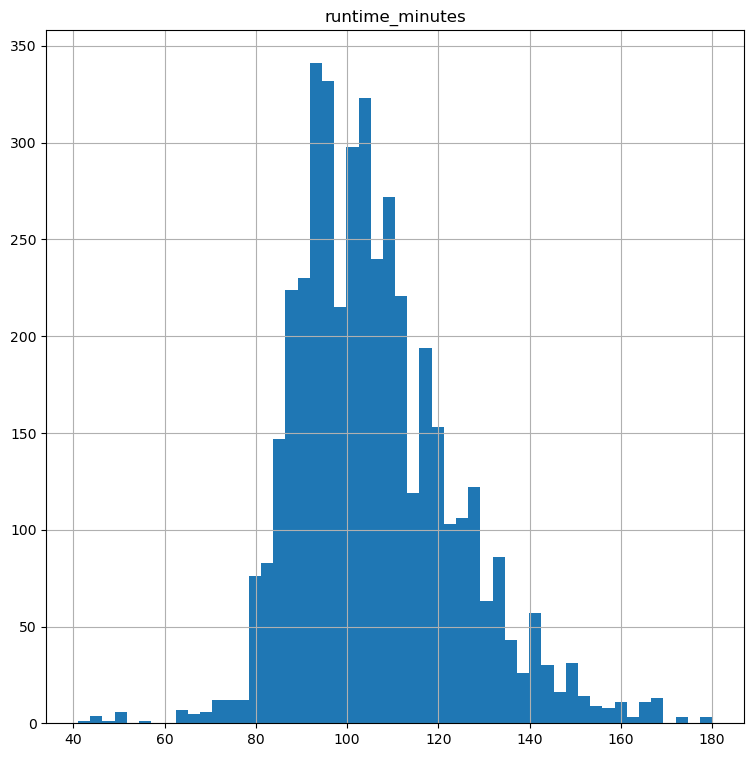

In [18]:
pd.DataFrame(runtime).hist(bins='auto',figsize=(9,9));

In [34]:
np.random.seed(15)

# Take random sample of size 500
sample_size = 500
sample = np.random.choice(a= runtime.shape[0],
                               size=500)

# Calculate sample mean and standard deviation
sample_mean = sample.mean()
sample_std = sample.std()

print ("Sample mean:", sample_mean)
print ("Sample std.:", sample_std)

print ("Difference between means:", runtime.mean() - sample_mean)

# Sample mean: 43.49 Sample std.: 12.98529552994463
# Difference between means: -0.5046680000000023

Sample mean: 2094.55
Sample std.: 1206.3293246456376
Difference between means: runtime_minutes   -1988.443082
dtype: float64
